In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.3.1


# Download the BigQuery dataset

In [39]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                        untar=True, cache_dir='.',
                        cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), '.')

In [40]:
os.listdir(dataset_dir)

['.ipynb_checkpoints',
 'README.md',
 'test',
 'train',
 'Text classification.ipynb',
 'stack_overflow_16k.tar.gz.tar.gz']

In [41]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['java', 'javascript', 'csharp', 'python']

In [42]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [43]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


## Explore Data 

In [87]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(5):
        print("Question", text_batch.numpy()[i])
        print("Labes", label_batch.numpy()[i])
        print()

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [47]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])
print("Label 3 corresponds to", raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [48]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [49]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './test',
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


## Prepare data for training

In [50]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                   '[%s]' % re.escape(string.punctuation),
                                   '')

In [69]:
max_features = 5000
sequence_length = 500

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [70]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

## Vectorize the data

In [71]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [72]:
text_batch, label_batch = next(iter(raw_train_ds))
first_question, first_label = text_batch[1], label_batch[1]
print("Question", first_question)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_question, first_label))

Question tf.Tensor(b'"tryparseexact always shows false i am trying to validate the date which is saved in string (20170123) but i am always getting false. can you please help me to get the true output. not getting any error when i execute it...sample given below:..bool testing =  datetime.tryparseexact(""20170123"", ""yyyy-mm-dd"", .cultureinfo.invariantculture, datetimestyles.adjusttouniversal, out datevalue);.           console.writeline(testing);"\n', shape=(), dtype=string)
Label csharp
Vectorized review (<tf.Tensor: shape=(1, 500), dtype=int64, numpy=
array([[   1,  338,  502,   96,    3,   34,   81,    4, 1021,    2,  161,
          66,    6, 1090,    7,   18,    1,   26,    3,   34,  338,  152,
          96,   35,   58,  160,  104,   74,    4,   41,    2,   88,  126,
          20,  152,   76,   65,   44,    3,  515,    1,  283,    1,  773,
           1, 4074,    1,    1,   94,    1,    1,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,

In [73]:
print("795 ---> ", vectorize_layer.get_vocabulary()[795])
print(" 23 ---> ", vectorize_layer.get_vocabulary()[23])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

795 --->  available
 23 --->  my
Vocabulary size: 5000


In [74]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

In [75]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build the model

In [76]:
embedding_dim = 128

In [77]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         640128    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 516       
Total params: 640,644
Trainable params: 640,644
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train the model 

In [79]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 7s 35ms/step - loss: 1.3735 - binary_accuracy: 0.2511 - val_loss: 1.3556 - val_binary_accuracy: 0.2466
Epoch 2/10
200/200 [==============================] - 6s 31ms/step - loss: 1.3197 - binary_accuracy: 0.2496 - val_loss: 1.2804 - val_binary_accuracy: 0.2475
Epoch 3/10
200/200 [==============================] - 7s 34ms/step - loss: 1.2208 - binary_accuracy: 0.2505 - val_loss: 1.1660 - val_binary_accuracy: 0.2497
Epoch 4/10
200/200 [==============================] - 7s 35ms/step - loss: 1.1017 - binary_accuracy: 0.2516 - val_loss: 1.0498 - val_binary_accuracy: 0.2492
Epoch 5/10
200/200 [==============================] - 6s 32ms/step - loss: 0.9882 - binary_accuracy: 0.2524 - val_loss: 0.9474 - val_binary_accuracy: 0.2484
Epoch 6/10
200/200 [==============================] - 6s 31ms/step - loss: 0.8905 - binary_accuracy: 0.2522 - val_loss: 0.8644 - val_binary_accuracy: 0.2511
Epoch 7/10
200/200 [==============================] - 6s 3

## Evaluate the model 

In [80]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 2s 8ms/step - loss: 0.7055 - binary_accuracy: 0.2581
Loss:  0.7055066823959351
Accuracy:  0.2580937445163727


In [81]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

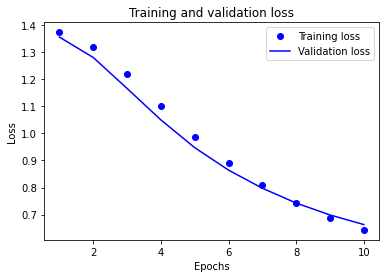

In [82]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

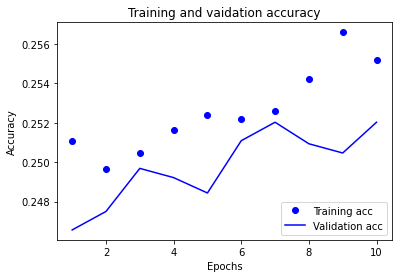

In [83]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and vaidation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [84]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model, 
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 11ms/step - loss: 0.9889 - accuracy: 0.7628
0.7627500295639038


In [85]:
examples = [
    "Can you help me with Python?",
    "Java question need to implement constructor.",
    "Does anybody know how to do delegates in C#?"
]

export_model.predict(examples)

array([[0.5195084 , 0.4662421 , 0.55737877, 0.42078257],
       [0.5398916 , 0.46352753, 0.5708885 , 0.39247692],
       [0.54119605, 0.4675379 , 0.5045139 , 0.44596452]], dtype=float32)